In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.io import loadmat
from scipy.signal import convolve, correlate, correlation_lags
from scipy.stats import norm
import torch
from torch.nn import BCEWithLogitsLoss
import tqdm

from sparks.models.encoders import HebbianTransformerEncoder
from sparks.models.decoders import mlp
from sparks.data.mec.mec_ca import make_mec_ca_dataset

# MEC slow oscillatory sequences 

`[Gonzalo Cogno, ..., Moser, Nature 2023]` have uncovered minutes-scale oscillatory sequences in the medial entorhinal cortex (MEC).
Let's have a look at the data.
When plotting the neurons in no particular order, their spike trains seem somewhat random.

In [2]:
data_path = os.path.join(os.getcwd(), 'calcium_activity_matrix_60584_session17.mat') # path to where the data is located.
# by default where the notebook is located, if the data isn't found it will be downloaded from 
# https://github.com/soledadgcogno/Ultraslow-oscillatory-sequences/blob/main/Selection%20of%20codes/calcium_activity_matrix_60584_session17.mat
if not os.path.exists(data_path):
    import urllib.request
    urllib.request.urlretrieve("https://github.com/soledadgcogno/Ultraslow-oscillatory-sequences/raw/main/Selection%20of%20codes/calcium_activity_matrix_60584_session17.mat", 
                               "calcium_activity_matrix_60584_session17.mat")
session_data = loadmat(data_path) # spikes saved in a matlab sparse matrix
spikes_idxs = session_data['spikes_d_s'].nonzero() # obtain the spike indices 
spikes = np.zeros(session_data['spikes_d_s'].shape) # reconstruct the histogram
spikes[spikes_idxs[0], spikes_idxs[1]] = 1
fs_120 = 7.73 # sampling rate

Text(0, 0.5, 'Neurons')

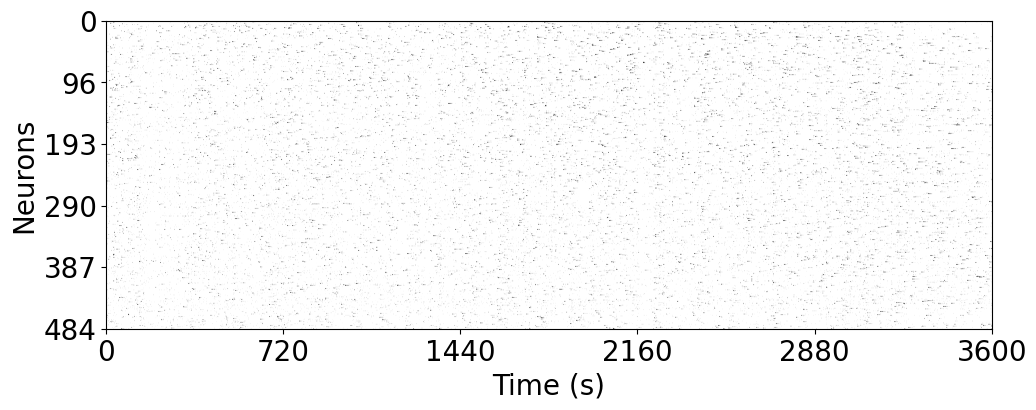

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.imshow(np.repeat(spikes, 20, 0), cmap='Greys')

T = spikes.shape[-1] / fs_120
ax.set_xticks(np.arange(0, int(spikes.shape[-1] + spikes.shape[-1] / 5), spikes.shape[-1] / 5))
ax.set_xticklabels(np.arange(0, T + T / 5, T / 5).astype(int), fontsize=20)
ax.set_xlabel('Time (s)', fontsize=20)

ax.set_yticks(np.arange(0, 20 * spikes.shape[0] + 20 * spikes.shape[0] / 5,
                        20 * spikes.shape[0] / 5))
ax.set_yticklabels(np.arange(0, spikes.shape[0] + spikes.shape[0] / 5, 
                             spikes.shape[0] / 5).astype(int), fontsize=20)
ax.set_ylabel('Neurons', fontsize=20)

However, in this work, they showed that they were able to find oscillatory sequences in the data after ordering the neurons. 
To find the correct ordering, they:
- downsample the data
- obtain smooth firing rates by convolving the spiking data with a gaussian kernel
- select a random neuron and sort the other ones based on the value of the peak of the correlation

The following helper functions compute all of these steps. 

In [4]:
def spikes_downsample(spikes, downsampling_factor, mode='mean'):
    """
    Downsamples the spikes by binning them
    
    Args:
        spikes: 
        downsampling_factor: 
        mode: 

    Returns:

    """
    bins = np.arange(0, spikes.shape[-1] + downsampling_factor, downsampling_factor)
    spike_times = spikes * np.arange(spikes.shape[-1])[None, :]
    if mode == 'mean':
        return np.vstack([(np.histogram(spike_times_unit[spike_times_unit != 0], bins)[0] / downsampling_factor)[None, :] for spike_times_unit in spike_times]).astype(float)
    elif mode == 'max':
        return np.vstack([(np.histogram(spike_times_unit[spike_times_unit != 0], bins)[0] > 0)[None, :] for spike_times_unit in spike_times]).astype(float)
    
def fire_rate(calcium_activity, bin_size):
    """
    Convolves the spike histogram with a Gaussian kernel to compute smooth firing rates
    
    Args:
        calcium_activity: 
        bin_size: 

    Returns:

    """
    # Define the Gaussian kernel
    kernel_width = 4 * bin_size
    x = np.linspace(-kernel_width, kernel_width, num=2*kernel_width, endpoint=False)
    gaussian_kernel = norm.pdf(x, scale=kernel_width)

    # Normalize the kernel
    gaussian_kernel /= np.sum(gaussian_kernel)

    # Convolve the calcium activity with the Gaussian kernel
    smoothed_activity = convolve(calcium_activity, gaussian_kernel, mode='same')

    return smoothed_activity

def sorting_xcorr(spikes, maxlag, downsampling_factor, dt_sf):
    """
    Computes correlations between the spike trains of each neurons,
    and stores the value of the correlation at the peak.
    Selects the neuron that has the highest peak, and sorts the other ones
    based on their peak wrt that neuron
    
    Args:
        spikes: 
        maxlag: 
        downsampling_factor: 
        dt_sf: 

    Returns:

    """
    FRp = spikes_downsample(spikes, downsampling_factor)

    FR = np.vstack([fire_rate(FRp[i], dt_sf) for i in range(len(FRp))])
    corr_mat = np.zeros([spikes.shape[0], spikes.shape[0]])

    for i in range(FR.shape[0]):
        for j in range(i+1, FR.shape[0]):
            val = correlate(FR[i], FR[j], mode='full')
            time = correlation_lags(len(FR[i]), len(FR[j]), mode='full')

            idx = np.argmax(val[np.abs(time) < maxlag])
            v = val[np.abs(time) < maxlag][idx]
            t = time[np.abs(time) < maxlag][idx]
    
            if t >= 0:
                corr_mat[i, j] = v
                corr_mat[j, i] = -v
            else:
                corr_mat[i, j] = -v
                corr_mat[j, i] = v

    r, c = np.unravel_index(np.argmax(corr_mat), corr_mat.shape)
    return np.argsort(corr_mat[c])

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def bce_loss(logits, targets):
    loss_fn = BCEWithLogitsLoss()
    logits = torch.tensor(logits)
    targets = torch.tensor(targets).unsqueeze(0)
    return np.mean([loss_fn(logits[..., t], targets[..., t]).numpy() for t in range(logits.shape[-1])])

Sorting neurons according to their correlation to an arbitrary neurons allows to uncover oscillations in the data! (see `[Gonzalo Cogno, ..., Moser, Nature 2023]`)

Text(0, 0.5, 'Neurons')

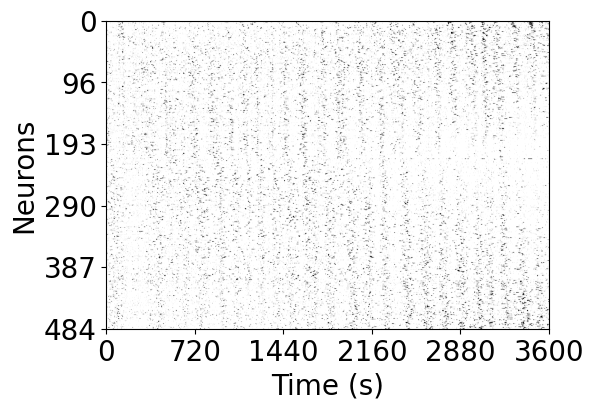

In [5]:
downsampling_factor = 4
fs = fs_120 / downsampling_factor

maxlag = 10
osc_bin_size = int(12 * fs)
sorting_corr = sorting_xcorr(spikes, maxlag, downsampling_factor, osc_bin_size)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
spikes_downsampled = spikes_downsample(spikes, downsampling_factor, mode='max')
ax.imshow(np.repeat(spikes_downsampled[sorting_corr], 10, 0), cmap='Greys')

T = spikes_downsampled.shape[-1] / fs
ax.set_xticks(np.arange(0, int(spikes_downsampled.shape[-1] + spikes_downsampled.shape[-1] / 5), spikes_downsampled.shape[-1] / 5))
ax.set_xticklabels(np.arange(0, T + T / 5, T / 5).astype(int), fontsize=20)
ax.set_xlabel('Time (s)', fontsize=20)

ax.set_yticks(np.arange(0, 10 * spikes_downsampled.shape[0] + 10 * spikes_downsampled.shape[0] / 5, 10 * spikes_downsampled.shape[0] / 5))
ax.set_yticklabels(np.arange(0, spikes_downsampled.shape[0] + spikes_downsampled.shape[0] / 5, spikes_downsampled.shape[0] / 5).astype(int), fontsize=20)
ax.set_ylabel('Neurons', fontsize=20)

Can SPARKS be applied to this data to gain insights into it?

## Create dataloader

In [6]:
start_stop_times_train = np.array([(600 + i * 500, 600 + (i + 1) * 500) for i in range(5)])
start_stop_times_test = np.array([[3100, 3600]])
data_path = os.path.join(os.getcwd(), 'calcium_activity_matrix_60584_session17.mat')
ds = 4

train_dataset, train_dl = make_mec_ca_dataset(data_path,
                                              start_stop_times=start_stop_times_train,
                                              downsampling_factor=ds,
                                              batch_size=5,
                                              train=True)

test_dataset, test_dl = make_mec_ca_dataset(data_path,
                                            start_stop_times=start_stop_times_test,
                                            downsampling_factor=ds,
                                            batch_size=5,
                                            train=False)

## Initialise model

In [7]:
embed_dim = 128  # attention embedding dimension
latent_dim = 64  # latent dimension
tau_s = 100  # STDP decay period (in seconds)
tau_p = 1  # past time-steps window
tau_f = 1  # future time-steps window
n_layers = 0  # number of conventional attention layers
n_heads = 1  # number of attention heads
input_size = len(train_dataset.spikes)
beta = 0.001  # KDL regularisation strength

# if a gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
# If on a recent macbook
elif torch.backends.mps.is_available():
    device = torch.device('mps:0')
else:
    device = torch.device('cpu')

encoding_network = HebbianTransformerEncoder(n_neurons_per_sess=input_size,
                                             embed_dim=embed_dim,
                                             latent_dim=latent_dim,
                                             tau_s_per_sess=tau_s,
                                             dt_per_sess=ds / 7.73,
                                             n_layers=n_layers,
                                             n_heads=n_heads).to(device)
n_inputs_decoder = latent_dim * tau_p
decoding_network = mlp(in_dim=n_inputs_decoder,
                       hid_features=int(np.mean([n_inputs_decoder, input_size])),
                       output_dim_per_session=input_size).to(device)

lr = 0.001
optimizer = torch.optim.Adam(list(encoding_network.parameters())
                             + list(decoding_network.parameters()), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
loss_fn = torch.nn.BCEWithLogitsLoss()

## Training and testing

Training is as simple as running the following loop 

In [8]:
from sparks.utils.train import train
from sparks.utils.test import test

test_period = 1
n_epochs = 1  # Number of training epochs

for epoch in range(n_epochs):
    train(encoder=encoding_network,
          decoder=decoding_network,
          train_dls=[train_dl],
          loss_fn=loss_fn,
          optimizer=optimizer,
          latent_dim=latent_dim,
          tau_p=tau_p,
          tau_f=tau_f,
          beta=beta,
          device=device)
    scheduler.step()

    if (epoch + 1) % test_period == 0:
        test_loss, encoder_outputs, decoder_outputs = test(encoder=encoding_network,
                                                           decoder=decoding_network,
                                                           test_dls=[test_dl],
                                                           latent_dim=latent_dim,
                                                           tau_p=tau_p,
                                                           tau_f=tau_f,
                                                           loss_fn=loss_fn,
                                                           device=device)

100%|██████████| 1/1 [00:15<00:00, 15.75s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:20<00:00, 20.05s/it]
1it [00:20, 20.05s/it]


Let's have a look at what happens behind the scene... This is what the training and test loops look like. 

In [9]:
for epoch in tqdm.tqdm(range(n_epochs)):
    train_iterator = iter(train_dl)
    decoding_network.train()
    encoding_network.train()

    for inputs, _ in train_iterator:
        ### Initialize training for a batch
        inputs = inputs.float()
        T = inputs.shape[-1]   # Number of time-steps in the recording
        encoding_network.zero_()  # Resets the attention layer
        
        # Initialize the outputs of the encoder as zeroes to match the input dimension of the decoder in the first time-steps
        encoder_outputs = torch.zeros([len(inputs), latent_dim, tau_p]).to(device)
        loss = 0

        for t in range(T - tau_f + 1):
            mu, logvar = encoding_network(inputs[..., t].to(device))  # Obtain the mean and std for the reparametrisation trick
            encoder_outputs = torch.cat((encoder_outputs, 
                                         encoding_network.reparametrize(mu, logvar).unsqueeze(2)), dim=-1) # apply the reparametrisation trick and save the results
            decoder_outputs = decoding_network(encoder_outputs[..., -tau_p:].reshape(len(encoder_outputs), -1))  # Obtain decoder outputs

            loss += (loss_fn(decoder_outputs,
                            inputs[..., t:t + tau_f].reshape(inputs.shape[0], -1).to(device)) 
                     - beta * 0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())) # Compute the current loss

        # Apply SGD at the end of the presentation of the batch ('batch training')
        loss.backward()
        optimizer.step()
        encoding_network.zero_grad()
        decoding_network.zero_grad()

100%|██████████| 1/1 [00:09<00:00,  9.52s/it]


### Testing loop

In [10]:
with torch.no_grad():
    test_iterator = iter(test_dl)
    decoding_network.eval()
    encoding_network.eval()

    encoder_outputs = torch.Tensor().to(device)
    decoder_outputs = torch.Tensor().to(device)
    test_targets = torch.Tensor()
    test_loss = 0

    for inputs, _ in tqdm.tqdm(test_iterator):
        inputs = inputs.float()
        T = inputs.shape[-1]
        encoding_network.zero_()
        encoder_outputs_batch = torch.zeros([len(inputs), tau_p, latent_dim]).to(device)
        decoder_outputs_batch = torch.Tensor().to(device)

        for t in range(T - tau_f + 1):
            mu, logvar = encoding_network(inputs[..., t].to(device))
            encoder_outputs_batch = torch.cat((encoder_outputs_batch,
                                               encoding_network.reparametrize(mu, logvar).unsqueeze(1)), dim=1)
            dec_outputs = decoding_network(encoder_outputs_batch[:, -tau_p:])

            decoder_outputs_batch = torch.cat((decoder_outputs_batch,
                                               dec_outputs.unsqueeze(2)), dim=-1)

        encoder_outputs = torch.cat((encoder_outputs, encoder_outputs_batch), dim=0)
        decoder_outputs = torch.cat((decoder_outputs, decoder_outputs_batch), dim=0)

100%|██████████| 1/1 [00:13<00:00, 13.48s/it]


# Looking at the results

Training on this example is not too long (~35s/epoch on a Macbook Pro M2 Max), but you may not want to wait for 100s of epochs to see the results. There are a few pre-trained models and their outputs in the examples/ folder. 

This first figure shows the results obtained to predict 500s of recording that were left out from the training data.
We trained two models, one implementing SPARKS, and the second implementing an alternative attention rule relying on symmetric STDP.
As you can see, both reach similar accuracy, but only SPARKS is able to recover the oscillatory sequences. 

Text(0, 0.5, 'Spike probability')

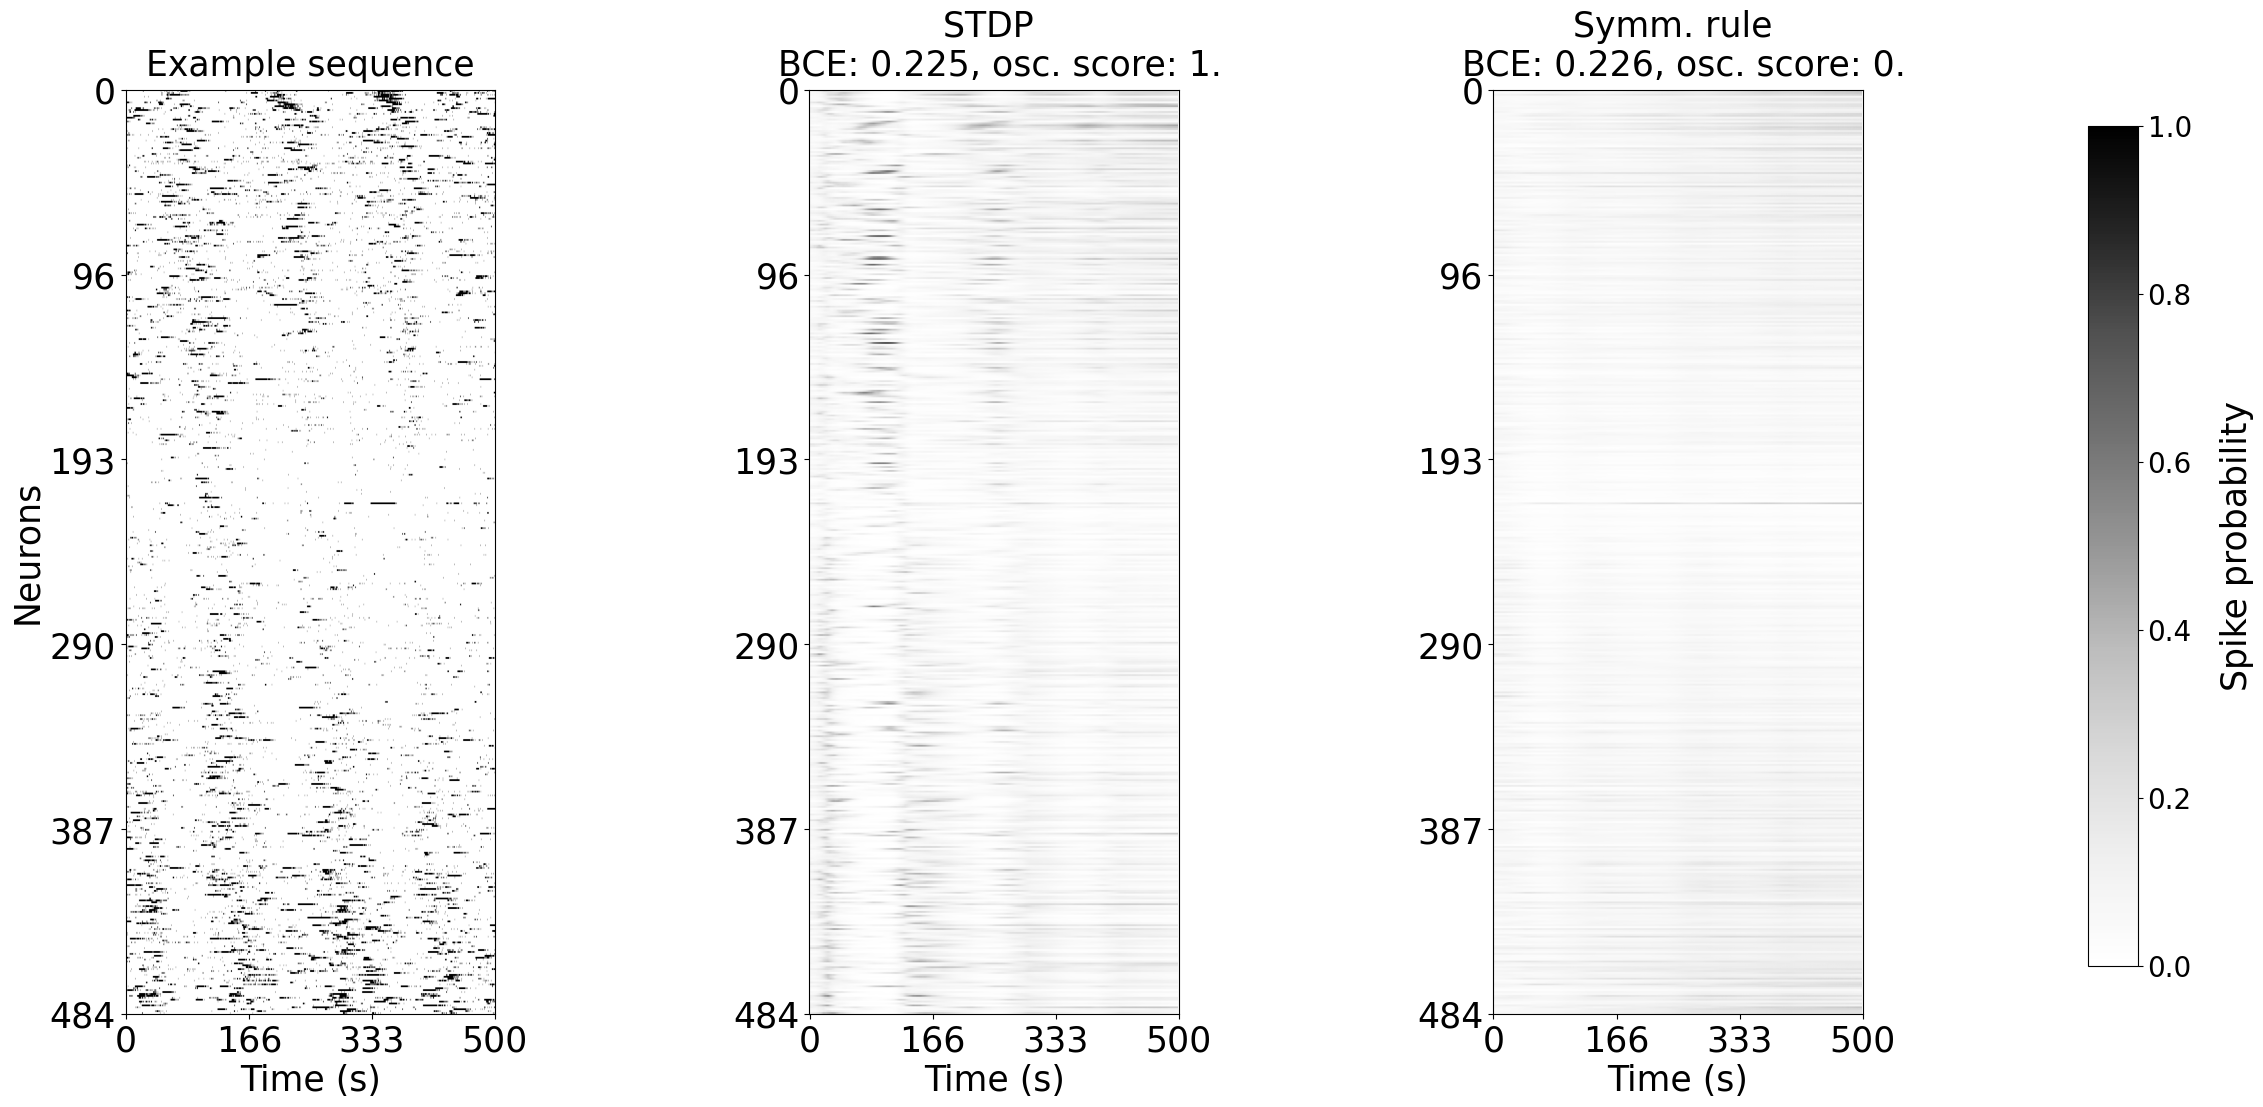

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(25, 12))

res_path = os.path.join(os.getcwd(), 'examples/mec_prediction_ca_example')
preds = np.load(os.path.join(res_path, 'dec_outputs_best.npy'))

start_stop_times_test = [3100, 3600]
spikes_test = spikes_downsampled[sorting_corr, int(start_stop_times_test[0] * fs):int(start_stop_times_test [1] * fs)]
T = spikes_test.shape[-1] / fs

ax[0].imshow(np.repeat(spikes_test, 5, 0), cmap='Greys')
ax[0].set_title('Example sequence', fontsize=25, pad=10)
ax[0].grid(False)
ax[0].set_xticks(np.arange(0, int(spikes_test.shape[-1] + spikes_test.shape[-1] / 3), spikes_test.shape[-1] / 3))
ax[0].set_xticklabels(np.arange(0, T + T / 3, T / 3).astype(int), fontsize=25)
ax[0].set_xlabel('Time (s)', fontsize=25)

ax[0].set_yticks(np.arange(0, 5 * spikes_test.shape[0] + 5 * spikes_test.shape[0] / 5, 5 * spikes_test.shape[0] / 5))
ax[0].set_yticklabels(np.arange(0, spikes_test.shape[0] + spikes_test.shape[0] / 5, spikes_test.shape[0] / 5).astype(int), fontsize=25)
ax[0].set_ylabel('Neurons', fontsize=25)

ax[1].imshow(sigmoid(np.repeat(preds[0], 5, 0)), cmap='Greys', vmin=0, vmax=1)
ax[1].grid(False)
ax[1].set_xticks(np.arange(0, int(spikes_test.shape[-1] + spikes_test.shape[-1] / 5), spikes_test.shape[-1] / 5))
ax[1].set_xticks(np.arange(0, int(spikes_test.shape[-1] + spikes_test.shape[-1] / 3), spikes_test.shape[-1] / 3))
ax[1].set_xticklabels(np.arange(0, T + T / 3, T / 3).astype(int), fontsize=25)
ax[1].set_yticks(np.arange(0, 5 * spikes_test.shape[0] + 5 * spikes_test.shape[0] / 5, 5 * spikes_test.shape[0] / 5))
ax[1].set_yticklabels(np.arange(0, spikes_test.shape[0] + spikes_test.shape[0] / 5, spikes_test.shape[0] / 5).astype(int), fontsize=25)
ax[1].set_title('STDP \n BCE: %.3f, osc. score: 1.' % bce_loss(preds, spikes_test), fontsize=25, pad=10)
ax[1].set_xlabel('Time (s)', fontsize=25)

res_path = os.path.join(os.getcwd(), 'examples/mec_prediction_ca_symm_example')
preds_symm = np.load(os.path.join(res_path, 'dec_outputs_best.npy'))
a = ax[2].imshow(sigmoid(np.repeat(preds_symm[0], 5, 0)), cmap='Greys', vmin=0, vmax=1)
ax[2].grid(False)
ax[2].set_xticks(np.arange(0, int(spikes_test.shape[-1] + spikes_test.shape[-1] / 5), spikes_test.shape[-1] / 5))
ax[2].set_xticks(np.arange(0, int(spikes_test.shape[-1] + spikes_test.shape[-1] / 3), spikes_test.shape[-1] / 3))
ax[2].set_xticklabels(np.arange(0, T + T / 3, T / 3).astype(int), fontsize=25)
ax[2].set_yticks(np.arange(0, 5 * spikes_test.shape[0] + 5 * spikes_test.shape[0] / 5, 5 * spikes_test.shape[0] / 5))
ax[2].set_yticklabels(np.arange(0, spikes_test.shape[0] + spikes_test.shape[0] / 5, spikes_test.shape[0] / 5).astype(int), fontsize=25)
ax[2].set_title('Symm. rule \n BCE: %.3f, osc. score: 0.' % bce_loss(preds_symm, spikes_test), fontsize=25, pad=10)
ax[2].set_xlabel('Time (s)', fontsize=25)

cb_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar = fig.colorbar(a, cax=cb_ax)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('Spike probability', fontsize=25, labelpad=20)

# What insights can we get from unsupervised learning?

Next, we investigate the insights we can gain from unsupervised learning with SPARKS.
To do so, we first plot the 2-dimensional latent embeddings obtained with our method.

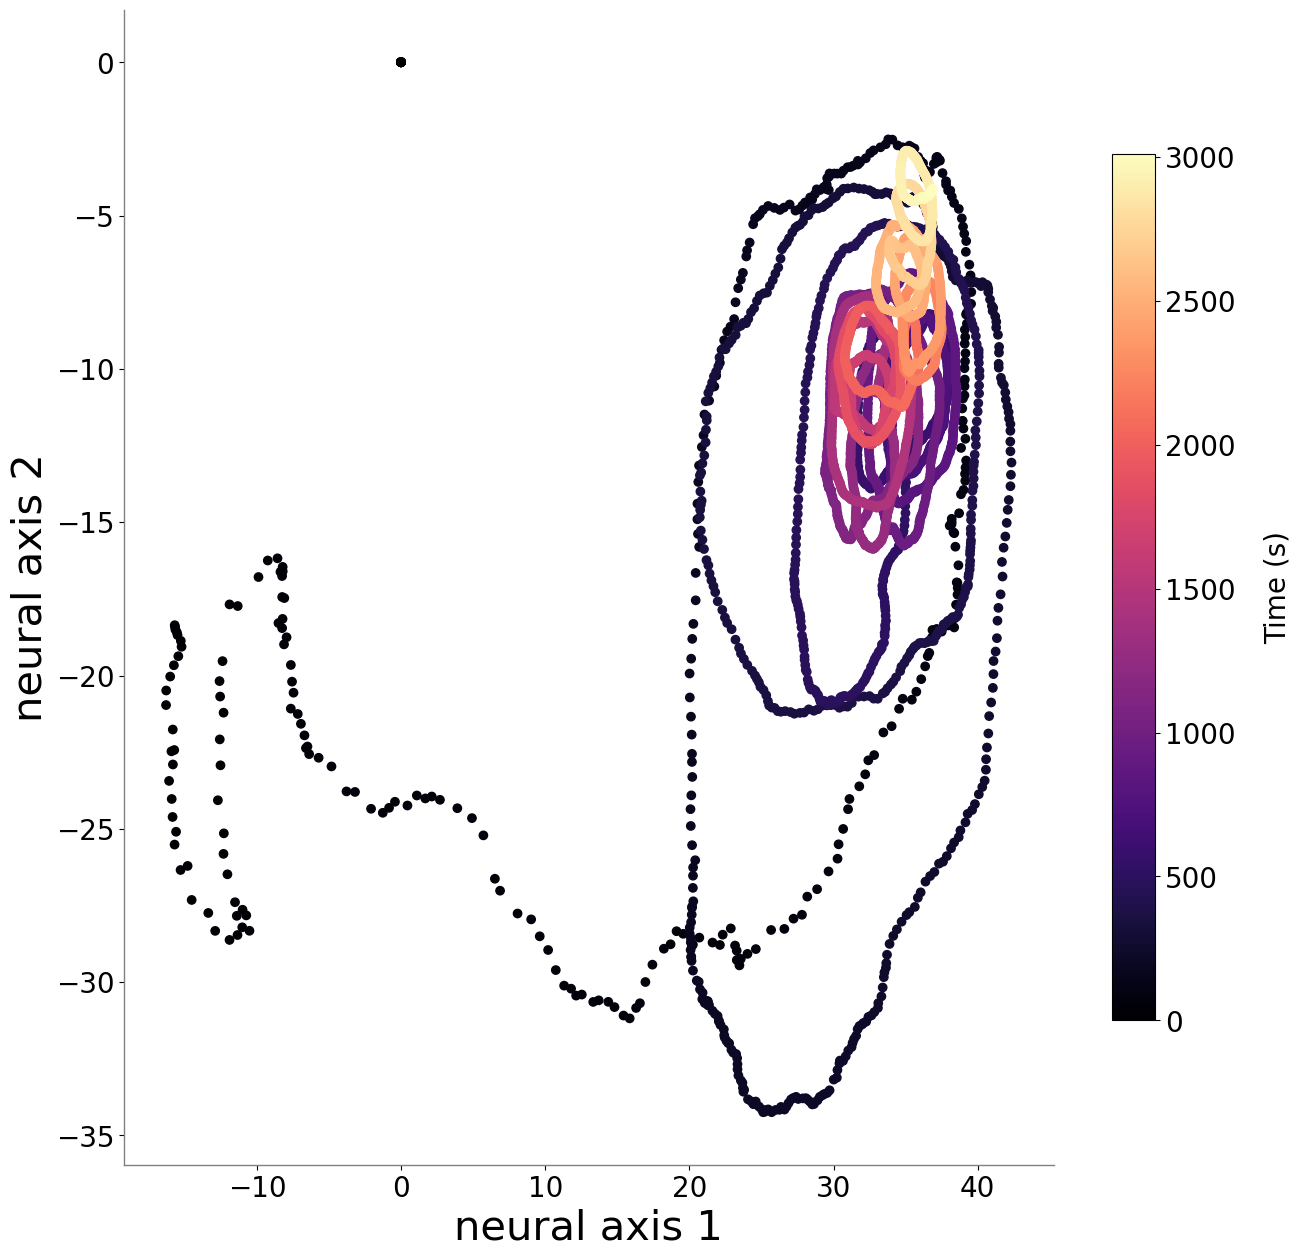

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

res_path = os.path.join(os.getcwd(), 'examples/mec_unsupervised_ca')
tau_p = 30

encodings = np.load(os.path.join(res_path, 'enc_outputs_best.npy'))[0, :, tau_p:]

a = ax.scatter(encodings[0], encodings[1], cmap = 'magma', c=np.arange(encodings.shape[-1])/fs)
ax.grid(False)

cbar = plt.colorbar(a, ax=ax, shrink=0.75)
cbar.ax.tick_params(labelsize=20) 
cbar.ax.set_ylabel('Time (s)', fontsize=20, labelpad=20)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('neural axis 1', fontsize=30)
ax.set_ylabel('neural axis 2', fontsize=30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines["left"].set_color('grey')
ax.spines["bottom"].set_color('grey')
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

As you may notice, the latent embeddings seem to follow a ring topology that shifts over time.
Can we recover the phase of the oscillations from this representation? 
To try and do so, we obtain the current centre of the ring as the average position of the embeddings over the last ~50s, which is relevant to the time-scale of the oscillations.
Then, we compute the angle between a segment that connects the centre of the ring to the current embedding, and a horizontal segment starting from the current embedding.
The functions below do all of these things. 

In [13]:
import math

def calculate_angle(segment1, segment2):
    """
    Calculate the angle in degrees between two segments
    Args:
        segment1: 
        segment2: 

    Returns:

    """
    # Convert the segments into vectors
    vec1 = (segment1[1][0] - segment1[0][0], segment1[1][1] - segment1[0][1])
    vec2 = (segment2[1][0] - segment2[0][0], segment2[1][1] - segment2[0][1])

    # Calculate the dot product
    dot_product = vec1[0] * vec2[0] + vec1[1] * vec2[1]

    # Calculate the magnitudes of the vectors
    mag_vec1 = math.sqrt(vec1[0]**2 + vec1[1]**2)
    mag_vec2 = math.sqrt(vec2[0]**2 + vec2[1]**2)

    # Calculate the cosine of the angle using the dot product and the magnitudes
    cos_angle = dot_product / (mag_vec1 * mag_vec2)

    # Use the arccos function to find the angle in radians, then convert it to degrees
    angle = math.degrees(math.acos(cos_angle))
    
    return angle

phi_t = []
window = 100 # window to find the centre of the circle
tau_p = 30

for t in range(encodings.shape[-1]):
    segment1 = (encodings[..., t], [encodings[0, t] + 10, encodings[1, t]])
    segment2 = (encodings[..., t], np.mean(encodings[..., max(0, t-window):max(t, window)], axis=-1))
    phi_t.append(calculate_angle(segment1, segment2))
phi_t = np.array(phi_t)

If we plot these phases, we do obtain nice, constant oscillations...

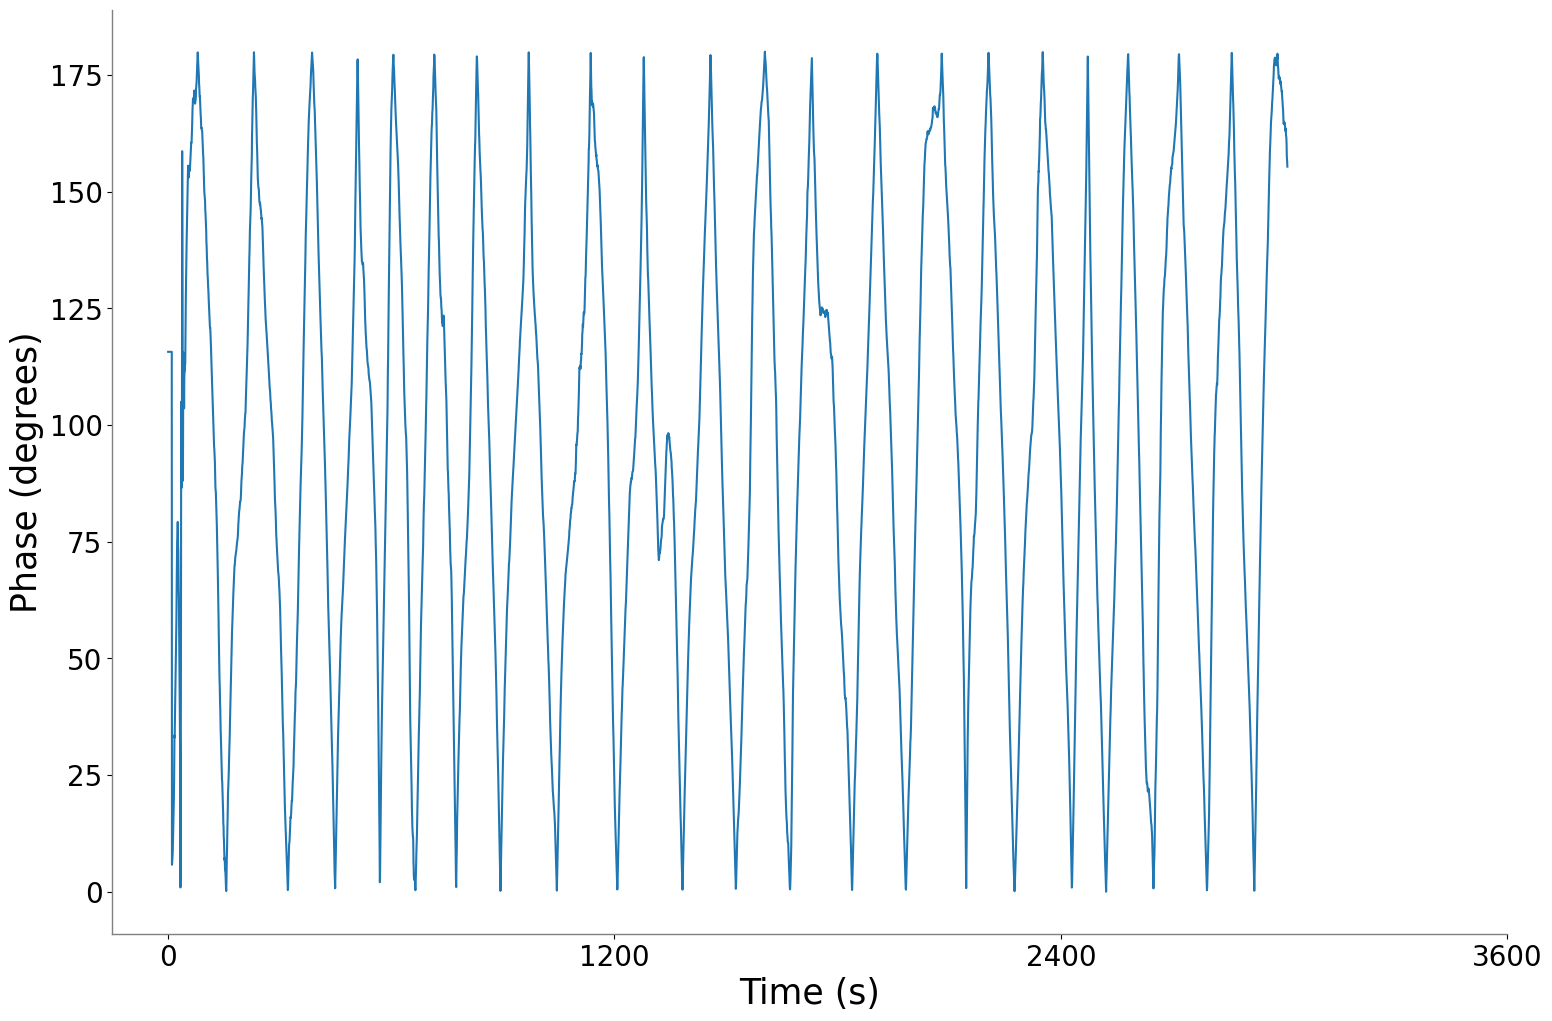

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

ax.plot(phi_t)
ax.set_ylabel('Phase (degrees)', fontsize=25)
ax.set_xlabel('Time (s)', fontsize=25)
ax.grid(False)
T = spikes_downsampled.shape[-1] / fs
ax.set_xticks(np.arange(0, int(spikes_downsampled.shape[-1] + spikes_downsampled.shape[-1] / 3), spikes_downsampled.shape[-1] / 3))
ax.set_xticklabels(np.arange(0, T + T / 3, T / 3).astype(int), fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines["left"].set_color('grey')
ax.spines["bottom"].set_color('grey')
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)
ax.tick_params(axis='both', which='major', labelsize=20)

... that overlay perfectly with the spiking signal!

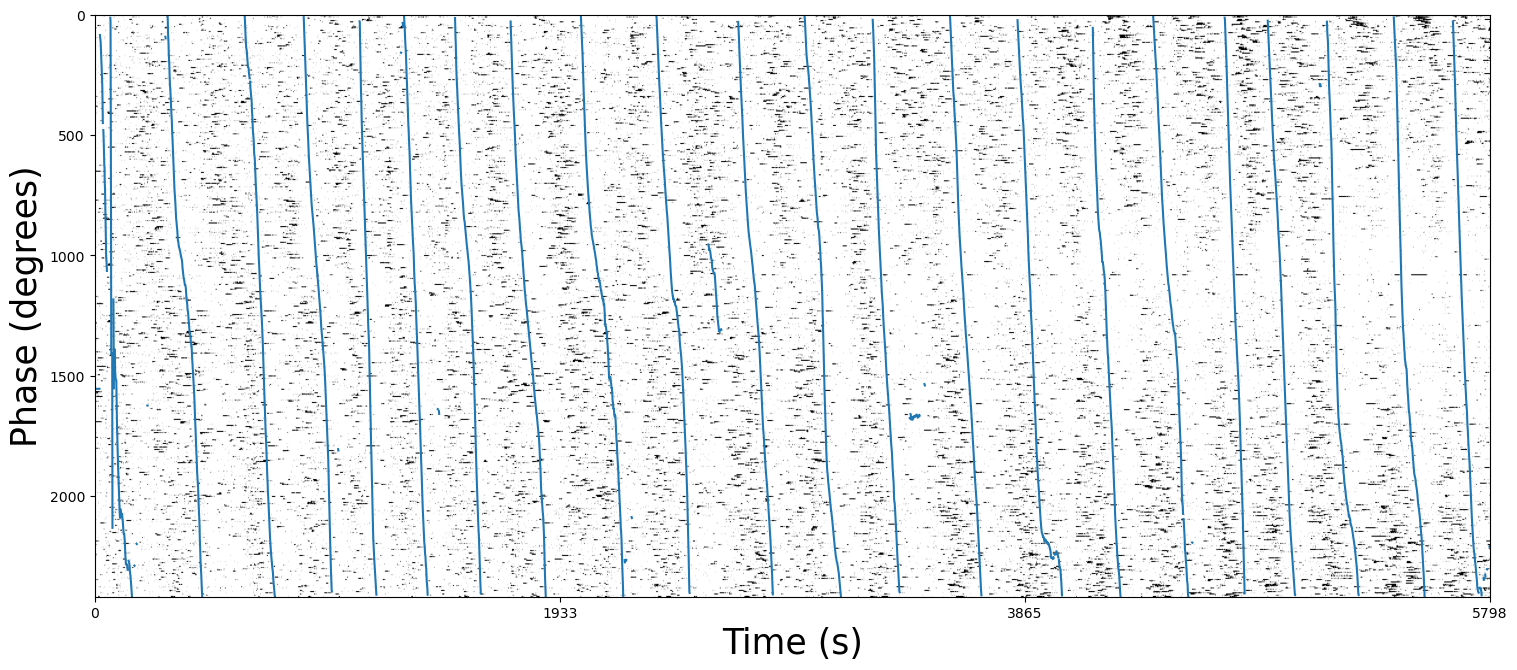

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

spikes_downsampled = spikes_downsample(spikes, downsampling_factor, mode='max')
spikes_downsampled = spikes_downsampled[sorting_corr, int(600 * fs): int(3600 * fs)]

# Obtain the phase in radians
for t in range(1, len(phi_t)):
    if phi_t[t] < phi_t[t-1]:
        phi_t[t] = None


ax.plot(phi_t / 180 * len(spikes_downsampled) * 5)
ax.imshow(np.repeat(spikes_downsampled, 5, 0), cmap='Greys')
ax.set_ylabel('Phase (degrees)', fontsize=25)
ax.set_xlabel('Time (s)', fontsize=25)
ax.grid(False)

T = spikes_downsampled.shape[-1] / fs
ax.set_xticks(np.arange(0, int(spikes_downsampled.shape[-1] + spikes_downsampled.shape[-1] / 3), spikes_downsampled.shape[-1] / 3))

So that seems to work, but in the absence of any knowledge of this sorting, would we have been able to uncover these oscillations using SPARKS?
To figure it out, we compute the correlation of each smoothed spiking sequence with the phase signal, and sort the neurons according to the peak of their correlation. 

In [ ]:
def sort_with_sparks(spikes, phase, maxlag, dt_sf):
    """
    Sort neurons based on their correlation factor with the phase signal
    Args:
        spikes: 
        phase: 
        maxlag: 
        dt_sf: 

    Returns:
    """

    FR = np.vstack([fire_rate(spikes[i], dt_sf) for i in range(len(spikes))])
    corr_vec = np.zeros(spikes.shape[0])

    for i in range(FR.shape[0]):
        val = correlate(FR[i], phase, mode='full')
        time = correlation_lags(len(FR[i]), len(phase), mode='full')
        idx = np.argmax(val[np.abs(time) < maxlag])
        v = val[np.abs(time) < maxlag][idx]
        t = time[np.abs(time) < maxlag][idx]

        if t >= 0:
            corr_vec[i] = v
        else:
            corr_vec[i] = -v
    
    return np.argsort(corr_vec)

sorting_sparks = sort_with_sparks(spikes_downsampled[:, int(600 * fs):], phi_t, maxlag, osc_bin_size)

It turns out this produces an even better sorting than that obtained with the technique proposed in the paper!

Text(0.5, 0, 'Time (s)')

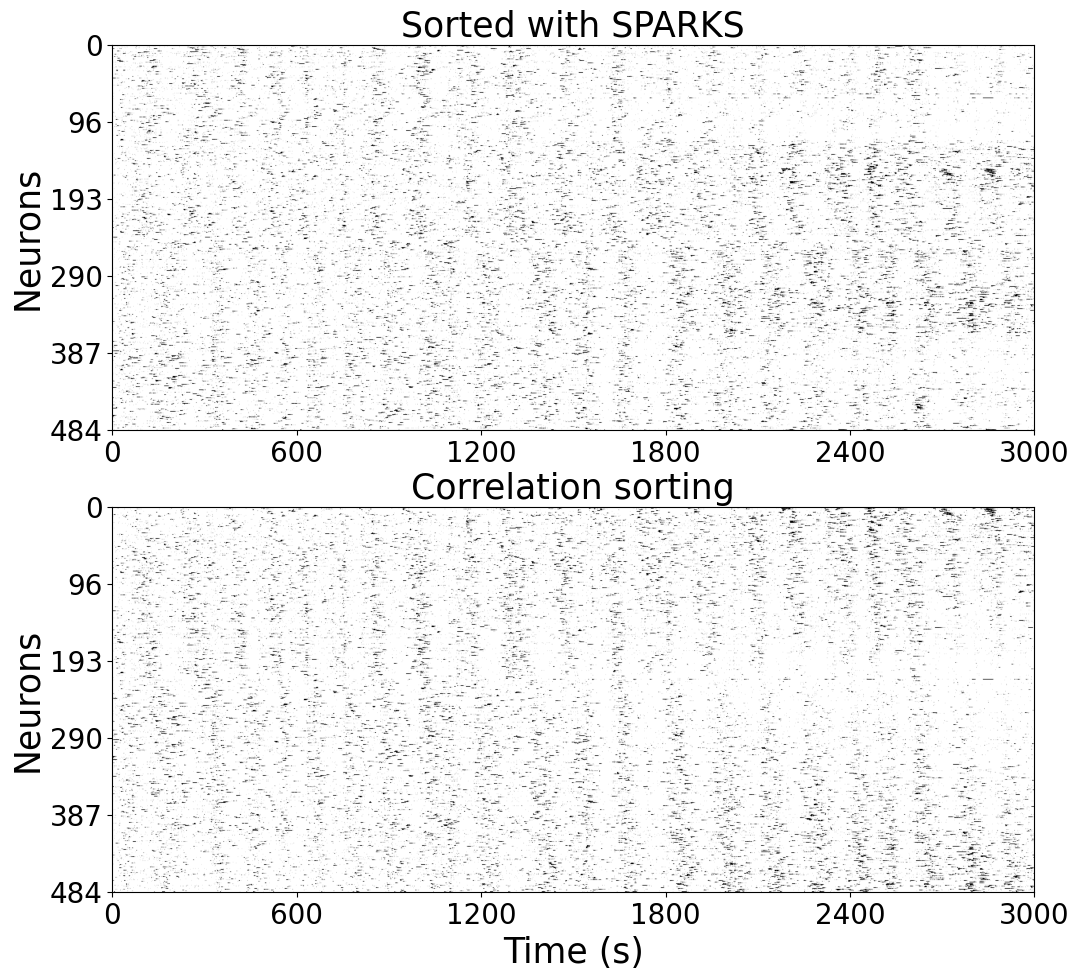

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(13, 11))

axs[0].imshow(np.flip(np.repeat(spikes_downsampled[sorting_sparks], 5, 0), axis=0), cmap='Greys')
axs[0].set_title('Sorted with SPARKS', fontsize=25)
axs[0].grid(False)

axs[1].imshow(np.repeat(spikes_downsampled, 5, 0), cmap='Greys')
axs[1].set_title('Correlation sorting', fontsize=25)
axs[1].grid(False)

for ax in axs:
    ax.set_xticks(np.arange(0, int(spikes_downsampled.shape[-1] + spikes_downsampled.shape[-1] / 5), spikes_downsampled.shape[-1] / 5))
    ax.set_xticklabels(np.arange(0, T + T / 5, T / 5).astype(int), fontsize=20)
    
    ax.set_yticks(np.arange(0, 5 * spikes_downsampled.shape[0] + 5 * spikes_downsampled.shape[0] / 5, 5 * spikes_downsampled.shape[0] / 5))
    ax.set_yticklabels(np.arange(0, spikes_downsampled.shape[0] + spikes_downsampled.shape[0] / 5, spikes_downsampled.shape[0] / 5).astype(int), fontsize=20)
    ax.set_ylabel('Neurons', fontsize=25)

axs[1].set_xlabel('Time (s)', fontsize=25)

In [18]:
!jupyter nbconvert --to html demo.ipynb

[NbConvertApp] Converting notebook demo.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).
[NbConvertApp] Writing 4370886 bytes to demo.html
